In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision
import torchvision.transforms as transforms
import torch
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import os
from re import L
import time
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

In [2]:
!nvidia-smi

Wed Jan 19 13:08:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.47       Driver Version: 466.47       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 25%   31C    P8     6W / 120W |    493MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# plant_loader.py
import matplotlib.pyplot as plt
import seaborn as sns

class PlantDataset(Dataset):
        def __init__(self, df, image_dir=f'data\\train_images\\'):

            std = 1. / 255.
            means = [109.97 / 255., 127.34 / 255., 123.88 / 255.]

            self.image_id = df['image'].values
            self.labels = df.iloc[:, 1:].values
            self.image_dir = image_dir
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=means,
                    std=[std]*3)
            ])

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            image_id = self.image_id[idx]
            label = torch.tensor(self.labels[idx].astype('int8'), dtype=torch.float32)
            
            image_path = self.image_dir + image_id
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = self.transform(image)

            return image, label

        @staticmethod
        def tensor_to_img(x, imtype=np.uint8):
            mean = [109.97 / 255., 127.34 / 255., 123.88 / 255.]
            std = [1. / 255., 1. / 255., 1. / 255.]

            if not isinstance(x, np.ndarray):
                if isinstance(x, torch.Tensor):  # get the data from a variable
                    image_tensor = x.data
                else:
                    return x
                image_numpy = image_tensor.cpu().float().numpy()  # convert it into a numpy array
                if image_numpy.shape[0] == 1:  # grayscale to RGB
                    image_numpy = np.tile(image_numpy, (3, 1, 1))
                for i in range(len(mean)):
                    image_numpy[i] = image_numpy[i] * std[i] + mean[i]
                image_numpy = image_numpy * 255
                image_numpy = np.transpose(image_numpy, (1, 2, 0))  # post-processing: tranpose and scaling
            else:  # if it is a numpy array, do nothing
                image_numpy = x
            return image_numpy.astype(imtype)

def get_plant_loader():

    #read data from csv
    df_train = pd.read_csv(f'data/train.csv')

    #label distribution
    train_count = df_train['labels'].value_counts()

    #plot original distribution
    #plt.figure(figsize=(20,12))
    #labels = sns.barplot(df_train.labels.value_counts().index,df_train.labels.value_counts())
    #for item in labels.get_xticklabels():
    #    item.set_rotation(45)
    
    #split labels
    df_train['labels'] = df_train['labels'].apply(lambda string: string.split(' '))
    #print(df_train.head(n=12))

    #make label in binary form
    train_df_list = list(df_train['labels'])
    mlb = MultiLabelBinarizer()
    trainx = pd.DataFrame(mlb.fit_transform(train_df_list), columns=mlb.classes_, index=df_train.index)
    
    #plot distribution after split
    #labels = list(trainx.sum().keys())
    #label_counts = trainx.sum().values.tolist()
    #fig, ax = plt.subplots(1,1, figsize=(20,6))
    #sns.barplot(x= labels, y= label_counts, ax=ax)
    
    #plot labels distribution
    #fig, ax = plt.subplots(figsize=(10,6))
    #trainx.sum().plot.bar(title='Target Class Distribution',width=0.2)
    #fig.savefig('plots/labels.png')

    #concat label in binary form with image name
    train_data = pd.concat([df_train, trainx], axis=1).drop('labels', axis=1)

    train, validation = train_test_split(train_data, train_size=0.9, random_state=11)    
    #test, validation = train_test_split(remaining, test_size=0.5)
    #print(train_data)

    #print(len(train), len(validation))

    return {
        "train": PlantDataset(train),
        "validation": PlantDataset(validation) 
        }
if __name__ == "__main__":
    path = 'plots'
    if not os.path.exists(path):
      os.makedirs(path)
    #get_plant_loader()

In [4]:
# pretrain_efficientNet.py

def log(msg):
    open('build/core.log', 'a').write(f'[{time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())}]\t'+msg+'\n'), print(msg)

def train(net, dataloader, optimizer, criterion, epoch):
    losses = 0
    losses20 = 0

    for step, (inputs, labels) in enumerate(dataloader, 0):
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        optimizer.zero_grad()
        outputs = net(inputs)

        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses += loss.item()
        losses20 += loss.item()

        if step % 20 == 0 and step != 0:
           avg_loss20 = losses20/20
           log(f':: loss @step({step:2d}/{len(dataloader)})-epoch{epoch}: {loss:.10f}\tavg_loss_20: {avg_loss20:.10f}')
           losses20 = 0

    avg_loss = losses/len(dataloader)
    #log(f':: loss @epoch{epoch}: avg_loss: {avg_loss:.10f}')
    return avg_loss

def eval(net, dataloader, epoch, interval):
    #log(' :: Testing on validation set ...')
    correct_top1 = 0
    #correct_top3 = 0
    #correct_top5 = 0

    accuracies = []
    
    for step, (inputs, labels) in enumerate(dataloader, 0):
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

        with torch.no_grad():
            logits = net(inputs)
            logits = torch.sigmoid(logits)
            logits[logits >= 0.5 ] = 1
            logits[logits < 0.5 ] = 0
            #print("logits:", logits, "labels:", labels)

            #accuracy = torch.all(torch.eq(logits, labels),  dim=1).sum()/len(labels)
            #print(accuracy)
            
            #accuracies += torch.all(torch.eq(logits, labels),  dim=1).sum()
            correct_top1 += torch.all(torch.eq(logits, labels),  dim=1).sum()
            current_accuracy = correct_top1/((step+1)*int(inputs.shape[0]))
            accuracies.append(current_accuracy.item())

            #print("step: ", step)
            #print(correct_top1/((step+1)*int(inputs.shape[0])))
            #correct_top1 += torch.eq(logits.topk(max((1, 1)), 1, True, True)[1], labels.view(-1, 1)).sum().float().item()
            #correct_top3 += torch.eq(logits.topk(max((1, 3)), 1, True, True)[1], labels.view(-1, 1)).sum().float().item()
            #correct_top5 += torch.eq(logits.topk(max((1, 5)), 1, True, True)[1], labels.view(-1, 1)).sum().float().item()

            if step % interval == 0 and step != 0:
               print(f':: accuracy @step({step:2d}/{len(dataloader)})-epoch{epoch}: {current_accuracy:.5%}')

        #if step == 57:
            #log(f'\tAccuracy@top1 ({step}/{len(dataloader)}) = {correct_top1/((step+1)*int(inputs.shape[0])):.5%}')
            #log(f'\tAccuracy@top3 ({step}/{len(dataloader)}) = {correct_top3/((step+1)*int(inputs.shape[0])):.5%}')
            #log(f'\tAccuracy@top5 ({step}/{len(dataloader)}) = {correct_top5/((step+1)*int(inputs.shape[0])):.5%}')
            #return correct_top1/((step+1)*int(inputs.shape[0]))
    tmp = np.array(accuracies)
    avg_accuracy = tmp.mean()
    return avg_accuracy 

def run():
    state_dict = torchvision.models.efficientnet_b0(pretrained=True).state_dict()
    state_dict.pop('classifier.1.weight')
    state_dict.pop('classifier.1.bias')
    net = torchvision.models.efficientnet_b0(num_classes=6).cuda()

    state_dict['classifier.1.weight'] = net.state_dict()['classifier.1.weight']
    state_dict['classifier.1.bias'] = net.state_dict()['classifier.1.bias']
    net.load_state_dict(state_dict)
    cudnn.benchmark = True

   
    #for param in net.parameters():
    #    print(type(param), param.size())

    criterion = torch.nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    data_set = get_plant_loader()

    trainloader = DataLoader(data_set["train"], batch_size=32, shuffle=True)
    validationloader = DataLoader(data_set["validation"], batch_size=32, shuffle=False)
    
    losses = []
    validation_accuracies = []
    training_accuracies = []

    # 15 epochs
    # 7 epochs = 77.48% cca
    for epoch in range(7):  # loop over the dataset multiple times
            accuracy = 0

            log(' :: Training on training set ...')
            avg_loss = train(net,trainloader,optimizer,criterion,epoch)
            log(f':: loss @epoch{epoch}: avg_loss: {avg_loss:.10f}')

            log(' :: Testing on validation set ...')
            temp_accuracy = eval(net, validationloader, epoch, 5)
            log(f':: validation set accuracy @epoch{epoch}: avg_accuracy: {temp_accuracy:.5%}')

            if temp_accuracy > accuracy :
                accuracy = temp_accuracy
                #stamp = f'e{epoch}{int(time.time())}'
                torch.save(net, f'build/efficientNet_b0_ImageNet.pt')
                torch.save(optimizer.state_dict, f'build/optimizer.pt')

            log(' :: Testing on training set ...')
            train_accuracy = eval(net, trainloader, epoch, 20)
            log(f':: training set accuracy @epoch{epoch}: avg_accuracy: {train_accuracy:.5%}')

            losses.append(avg_loss)
            validation_accuracies.append(temp_accuracy)
            training_accuracies.append(train_accuracy)

    np.savetxt(f'logs/efficientNet_b0-loss.csv',losses,'%.10f',',')
    np.savetxt(f'logs/efficientNet_b0-validation_accuracy.csv',validation_accuracies,'%.10f',',')
    np.savetxt(f'logs/efficientNet_b0-training_accuracy.csv',training_accuracies,'%.10f',',')
    

if __name__ == "__main__":
    path = 'build'
    if not os.path.exists(path):
        os.makedirs(path)
    path = 'logs'
    if not os.path.exists(path):
        os.makedirs(path)
    #run()


In [5]:
# model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision


class AttentionCropFunction(torch.autograd.Function):
    @staticmethod
    def forward(self, images, locs):
        
        def h(_x): return 1 / (1 + torch.exp(-10 * _x.float()))

        #in_size = 224
        in_size = images.size()[2]
        #unit = tensor([[  0,   1,   2,  ..., 221, 222, 223],
        #               [  0,   1,   2,  ..., 221, 222, 223],
        #               [  0,   1,   2,  ..., 221, 222, 223],
        #               ...,
        #               [  0,   1,   2,  ..., 221, 222, 223],
        #               [  0,   1,   2,  ..., 221, 222, 223],
        #               [  0,   1,   2,  ..., 221, 222, 223]])
        unit = torch.stack([torch.arange(0, in_size)] * in_size)
        #x è 3 tensor([[[  0,   0,   0,  ...,   0,   0,   0],
        #               [  1,   1,   1,  ...,   1,   1,   1],
        #               [  2,   2,   2,  ...,   2,   2,   2],
        #               ...,
        #               [221, 221, 221,  ..., 221, 221, 221],
        #               [222, 222, 222,  ..., 222, 222, 222],
        #               [223, 223, 223,  ..., 223, 223, 223]]
        x = torch.stack([unit.t()] * 3)
        #y è 3 tensori unit
        y = torch.stack([unit] * 3)
        if isinstance(images, torch.cuda.FloatTensor):
            x, y = x.cuda(), y.cuda()

        in_size = images.size()[2]
        ret = []

        #processa tutte le immagini del batch, in questo caso images.size(0) è 12
        for i in range(images.size(0)):
            # locs sono tensor([[143.3381, 124.7122,  51.1188],
            #                   [110.5597, 137.9310,  60.7936],
            #                   [119.1002,  99.9731,  52.5289],
            #                   [113.5314, 129.4575,  46.4848],
            #                   [ 79.8117,  94.2794,  54.7804],
            #                   [117.5080, 136.6172,  63.8196],
            #                   [ 87.7556, 113.1122,  62.1823],
            #                   [131.8735, 108.5016,  63.9460],
            #                   [ 99.1213, 125.6766,  76.2739],
            #                   [ 90.7646,  89.5686,  49.1010],
            #                   [ 84.4682, 130.7239,  82.1634],
            #                   [ 88.4385,  96.4715,  42.9040]], device='cuda:0',
            #               grad_fn=<MulBackward0>)

            tx, ty, tl = locs[i][0], locs[i][1], locs[i][2]
            
            #per evitare che si rimpicciolisca troppo
            tl = tl if tl > (in_size/3) else in_size/3
            #check per evitare che il crop "sbordi"
            tx = tx if tx > tl else tl
            tx = tx if tx < in_size-tl else in_size-tl
            ty = ty if ty > tl else tl
            ty = ty if ty < in_size-tl else in_size-tl
            
            # in un esempio, w_off, h_off, w_end, h_end 68 50 218 199
            w_off = int(tx-tl) if (tx-tl) > 0 else 0
            h_off = int(ty-tl) if (ty-tl) > 0 else 0
            w_end = int(tx+tl) if (tx+tl) < in_size else in_size
            h_end = int(ty+tl) if (ty+tl) < in_size else in_size
            
            #mk cosa fa di preciso?????
            mk = (h(x-w_off) - h(x-w_end)) * (h(y-h_off) - h(y-h_end))
            xatt = images[i] * mk
            xatt_cropped = xatt[:, w_off: w_end, h_off: h_end]
            before_upsample = Variable(xatt_cropped.unsqueeze(0))
            #fa l'upsampling dell'immagine croppata a 224x224
            xamp = F.upsample(before_upsample, size=(224, 224), mode='bilinear', align_corners=True)
            ret.append(xamp.data.squeeze())

        ret_tensor = torch.stack(ret)
        self.save_for_backward(images, ret_tensor)
        return ret_tensor

    @staticmethod
    def backward(self, grad_output):
        images, ret_tensor = self.saved_variables[0], self.saved_variables[1]
        in_size = 224
        ret = torch.Tensor(grad_output.size(0), 3).zero_()
        norm = -(grad_output * grad_output).sum(dim=1)
        x = torch.stack([torch.arange(0, in_size)] * in_size).t()
        y = x.t()
        long_size = (in_size/3*2)
        short_size = (in_size/3)
        mx = (x >= long_size).float() - (x < short_size).float()
        my = (y >= long_size).float() - (y < short_size).float()
        ml = (((x < short_size)+(x >= long_size)+(y < short_size)+(y >= long_size)) > 0).float()*2 - 1

        mx_batch = torch.stack([mx.float()] * grad_output.size(0))
        my_batch = torch.stack([my.float()] * grad_output.size(0))
        ml_batch = torch.stack([ml.float()] * grad_output.size(0))

        if isinstance(grad_output, torch.cuda.FloatTensor):
            mx_batch = mx_batch.cuda()
            my_batch = my_batch.cuda()
            ml_batch = ml_batch.cuda()
            ret = ret.cuda()

        ret[:, 0] = (norm * mx_batch).sum(dim=1).sum(dim=1)
        ret[:, 1] = (norm * my_batch).sum(dim=1).sum(dim=1)
        ret[:, 2] = (norm * ml_batch).sum(dim=1).sum(dim=1)
        return None, ret


class AttentionCropLayer(nn.Module):
    """
        Crop function sholud be implemented with the nn.Function.
        Detailed description is in 'Attention localization and amplification' part.
        Forward function will not changed. backward function will not opearate with autograd, but munually implemented function
    """

    def forward(self, images, locs):
        return AttentionCropFunction.apply(images, locs)


class RACNN(nn.Module):
    def __init__(self, num_classes, img_scale=448):
        super(RACNN, self).__init__()

        self.b1 = torchvision.models.efficientnet_b0(num_classes=num_classes)
        self.b2 = torchvision.models.efficientnet_b0(num_classes=num_classes)
        self.b3 = torchvision.models.efficientnet_b0(num_classes=num_classes)

        self.classifier1 = nn.Linear(320, num_classes)
        self.classifier2 = nn.Linear(320, num_classes)
        self.classifier3 = nn.Linear(320, num_classes)

        self.feature_pool = torch.nn.AdaptiveAvgPool2d(output_size=1)
        #self.atten_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.crop_resize = AttentionCropLayer()

        #l'output delle due apn sono 3 valori, che indicano x,y,l
        self.apn1 = nn.Sequential(
            nn.Linear(320 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 3),
            nn.Tanh(),
        )

        self.apn2 = nn.Sequential(
            nn.Linear(320 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 3),
            nn.Tanh(),
        )
        
        self.echo = None

    def forward(self, x):
        #batch_size = x.shape[0]
        rescale_tl = torch.tensor([1, 1, 0.5], requires_grad=False).cuda()
        # forward @scale-1
        feature_s1 = self.b1.features[:-1](x)  # torch.Size([batch_size, 320, 7, 7])
        pool_s1 = self.feature_pool(feature_s1) # torch.Size([batch_size, 320, 1, 1])
        _attention_s1 = self.apn1(feature_s1.view(-1, 320 * 7 * 7))
        attention_s1 = _attention_s1*rescale_tl
        resized_s1 = self.crop_resize(x, attention_s1 * x.shape[-1])
        # forward @scale-2
        feature_s2 = self.b2.features[:-1](resized_s1)  # torch.Size([1, 320, 7, 7])
        pool_s2 = self.feature_pool(feature_s2)
        _attention_s2 = self.apn2(feature_s2.view(-1, 320 * 7 * 7))
        attention_s2 = _attention_s2*rescale_tl
        resized_s2 = self.crop_resize(resized_s1, attention_s2 * resized_s1.shape[-1])
        # forward @scale-3
        feature_s3 = self.b3.features[:-1](resized_s2)
        pool_s3 = self.feature_pool(feature_s3)
        pred1 = self.classifier1(pool_s1.view(-1, 320))
        pred2 = self.classifier2(pool_s2.view(-1, 320))
        pred3 = self.classifier3(pool_s3.view(-1, 320))
        return [pred1, pred2, pred3], [feature_s1, feature_s2], [attention_s1, attention_s2], [resized_s1, resized_s2]

    def __get_weak_loc(self, features):
        ret = []   # search regions with the highest response value in conv5
        for i in range(len(features)):
            resize = 224 if i >= 1 else 448
            response_map_batch = F.interpolate(features[i], size=[resize, resize], mode="bilinear").mean(1)  # mean alone channels
            ret_batch = []
            for response_map in response_map_batch:
                argmax_idx = response_map.argmax()
                ty = (argmax_idx % resize)
                argmax_idx = (argmax_idx - ty)/resize
                tx = (argmax_idx % resize)
                ret_batch.append([(tx*1.0/resize).clamp(min=0.25, max=0.75), (ty*1.0/resize).clamp(min=0.25, max=0.75), 0.25])  # tl = 0.25, fixed
            ret.append(torch.Tensor(ret_batch))
        return ret

    def __echo_pretrain_apn(self, inputs, optimizer):
        inputs = Variable(inputs).cuda()
        _, features, attens, _ = self.forward(inputs)
        weak_loc = self.__get_weak_loc(features)
        optimizer.zero_grad()
        weak_loss1 = F.smooth_l1_loss(attens[0], weak_loc[0].cuda())
        weak_loss2 = F.smooth_l1_loss(attens[1], weak_loc[1].cuda())
        loss = weak_loss1 + weak_loss2
        #calcola il gradiente della loss
        loss.backward()
        #perform a single optimization step
        optimizer.step()
        #ritorna la loss come un singolo numero anziche un tensore
        return loss.item()

    @staticmethod
    def multitask_loss(logits, targets):
        loss = []
        criterion = torch.nn.BCEWithLogitsLoss()
        criterion = criterion
        for i in range(len(logits)):
            loss.append(criterion(logits[i], targets))
        loss = torch.sum(torch.stack(loss))
        return loss

    @staticmethod
    def rank_loss(logits, targets, margin=0.05):
        #as said in the paper
        preds = [torch.sigmoid(x) for x in logits] # preds length equal to 3
        losses = []
        criterion = torch.nn.MarginRankingLoss(margin=0.05)
        for pred in preds:
            loss = []
            for i in range(len(pred)-1):
                #the loss is the diff between cnn predictions
                #rank_loss = (pred[i]-pred[i+1] + margin).clamp(min = 0)
                y = Variable(torch.Tensor(pred[0].size(0)).fill_(-1)).cuda()
                rank_loss = criterion(pred[i], pred[i+1], y)
                loss.append(rank_loss)
            loss = torch.sum(torch.stack(loss))
            losses.append(loss)
        losses = torch.stack(losses)
        losses = torch.sum(losses)
        return losses
    
    def __echo_backbone(self, inputs, targets, optimizer):
        inputs, targets = Variable(inputs).cuda(), Variable(targets).cuda()
        logits, _, _, _ = self.forward(inputs)
        optimizer.zero_grad()
        # logit --> the vector of raw (non-normalized) predictions that a classification model generates
        loss = self.multitask_loss(logits, targets)
        loss.backward()
        optimizer.step()
        return loss.item()

    def __echo_apn(self, inputs, targets, optimizer):
        inputs, targets = Variable(inputs).cuda(), Variable(targets).cuda()
        logits, _, _, _ = self.forward(inputs)
        optimizer.zero_grad()
        loss = self.rank_loss(logits, targets)
        loss.backward()
        optimizer.step()
        return loss.item()

    def mode(self, mode_type):
        assert mode_type in ['pretrain_apn', 'apn', 'backbone']
        if mode_type == 'pretrain_apn':
            self.echo = self.__echo_pretrain_apn
            self.eval()
        if mode_type == 'backbone':
            self.echo = self.__echo_backbone
            self.train()
        if mode_type == 'apn':
            self.echo = self.__echo_apn
            self.eval()


#if __name__ == "__main__":
#    net = RACNN(num_classes=6).cuda()
#    net.mode('pretrain_apn')
#    optimizer = torch.optim.SGD(list(net.apn1.parameters()) + list(net.apn2.parameters()), lr=0.001, momentum=0.9)
#    for i in range(50):
#        inputs = torch.rand(2, 3, 448, 448)
#        print(f':: loss @step{i} : {net.echo(inputs, optimizer)}')


 :: Cleaning cache dir ...


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\gabri\AppData\Local\Temp/ipykernel_8052/3993585667.py:89: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  images, ret_tensor = self.saved_variables[0], self.saved_variables[1]


:: loss @step 0: 0.5570628643035889	avg_loss_5: 0.5570628643035889
0
:: loss @step 1: 0.20652124285697937	avg_loss_5: 0.3817920535802841
1
:: loss @step 2: 0.09563125669956207	avg_loss_5: 0.2864051212867101
2
:: loss @step 3: 0.12864725291728973	avg_loss_5: 0.246965654194355
3
:: loss @step 4: 0.14423291385173798	avg_loss_5: 0.2264191061258316
4
:: loss @step 5: 0.15619944036006927	avg_loss_5: 0.14624642133712767
5
:: loss @step 6: 0.1331322193145752	avg_loss_5: 0.13156861662864686
6
:: loss @step 7: 0.16473954916000366	avg_loss_5: 0.14539027512073516
7
:: loss @step 8: 0.14791493117809296	avg_loss_5: 0.1492438107728958
8
:: loss @step 9: 0.13092544674873352	avg_loss_5: 0.14658231735229493
9
:: loss @step10: 0.14041820168495178	avg_loss_5: 0.14342606961727142
10
:: loss @step11: 0.1303066611289978	avg_loss_5: 0.14286095798015594
11
:: loss @step12: 0.1322145313024521	avg_loss_5: 0.13635595440864562
12
:: loss @step13: 0.09797797352075577	avg_loss_5: 0.12636856287717818
13
:: loss @step

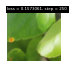

In [6]:
# pretrain_apn.py

import shutil
import cv2
import imageio
import os
import numpy as np
import sys
import torch
import time
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append('.')  # noqa: E402
from torch.autograd import Variable



def log(msg):
    open('build/core.log', 'a').write(f'[{time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())}]\t'+msg+'\n'), print(msg)


def random_sample(dataloader):
    for batch_idx, (inputs, _) in enumerate(dataloader, 0):
        return inputs[0].cuda()


def save_img(x, path, annotation=''):
    fig = plt.gcf()  # generate outputs
    plt.imshow(PlantDataset.tensor_to_img(x[0]), aspect='equal'), plt.axis('off'), fig.set_size_inches(224/100.0/3.0, 224/100.0/3.0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator()), plt.gca().yaxis.set_major_locator(plt.NullLocator()), plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0), plt.margins(0, 0)
    plt.text(0, 0, annotation, color='white', size=4, ha="left", va="top", bbox=dict(boxstyle="square", ec='black', fc='black'))
    plt.savefig(path, dpi=300, pad_inches=0)    # visualize masked image


def run(pretrained_backbone=None):
    net = RACNN(num_classes=6).cuda()
    if pretrained_backbone:  # Using pretrained backbone for apn pretraining
        state_dict = torch.load(pretrained_backbone).state_dict()
        net.b1.load_state_dict(state_dict)
        net.b2.load_state_dict(state_dict)
        net.b3.load_state_dict(state_dict)

    cudnn.benchmark = True

    params = list(net.apn1.parameters()) + list(net.apn2.parameters())
    optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

    data_set = get_plant_loader()
    trainloader = torch.utils.data.DataLoader(data_set["train"], batch_size=4, shuffle=True)
    validationloader = torch.utils.data.DataLoader(data_set["validation"], batch_size=8, shuffle=False)
    sample = random_sample(validationloader)
    
    net.mode("pretrain_apn")

    def avg(x): return sum(x)/len(x)
    for epoch in range(1):
        losses = []
        for step, (inputs, _) in enumerate(trainloader, 0):

            loss = net.echo(inputs, optimizer)
            losses.append(loss)
            avg_loss = avg(losses[-5 if len(losses) > 5 else -len(losses):])
            print(f':: loss @step{step:2d}: {loss}\tavg_loss_5: {avg_loss}')

            if step % 2 == 0 or step < 5:  # check point
                _, _, _, resized = net(sample.unsqueeze(0))
                x1, x2 = resized[0].data, resized[1].data
                # visualize cropped inputs
                save_img(x1, path=f'build/.cache/step_{step}@2x.jpg', annotation=f'loss = {avg_loss:.7f}, step = {step}')
                save_img(x2, path=f'build/.cache/step_{step}@4x.jpg', annotation=f'loss = {avg_loss:.7f}, step = {step}')
            print(step)
            if step >= 250:  # 128 steps is enough for pretraining
                torch.save(net.state_dict(), f'build/racnn_pretrained.pt')
                return


def build_gif(pattern='@2x', gif_name='pretrain_apn_EfficientNet', cache_path='build/.cache'):
    # generate a gif, enjoy XD
    files = [x for x in os.listdir(cache_path) if pattern in x]
    files.sort(key=lambda x: int(x.split('@')[0].split('_')[-1]))
    gif_images = [imageio.imread(f'{cache_path}/{img_file}') for img_file in files]
    imageio.mimsave(f"build/{gif_name}{pattern}-{int(time.time())}.gif", gif_images, fps=8)


def clean(path='build/.cache/'):
    print(' :: Cleaning cache dir ...')
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)


if __name__ == "__main__":
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    clean()
    run(pretrained_backbone='build/efficientNet_b0_ImageNet.pt')
    build_gif(pattern='@2x', gif_name='pretrain_apn_EfficientNet')
    build_gif(pattern='@4x', gif_name='pretrain_apn_EfficientNet')


In [7]:
# forge.py

import imageio
import os
import shutil
import sys
from scipy.sparse import data
import torch
import time
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.autograd import Variable


sys.path.append('.')  # noqa: E402



def avg(x): return sum(x)/len(x)

def train(net, dataloader, optimizer, epoch, _type):
    assert _type in ['apn', 'backbone']
    losses = 0
    net.mode(_type), log(f' :: Switch to {_type}')  # switch loss type
    for step, (inputs, targets) in enumerate(dataloader, 0):
        loss = net.echo(inputs, targets, optimizer)
        losses += loss

        if step % 20 == 0 and step != 0:
            avg_loss = losses/20
            log(f':: loss @step({step:2d}/{len(dataloader)})-epoch{epoch}: {loss:.10f}\tavg_loss_20: {avg_loss:.10f}')
            losses = 0

    return avg_loss


def test(net, dataloader):
    correct = [0,0,0]
    cnt = 0
    avg_accuracy = 0

    for step, (inputs, labels) in enumerate(dataloader, 0):
        inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
        cnt += inputs.size(0)
        with torch.no_grad():
            outputs, _, _, _ = net(inputs)
            for idx, logits in enumerate(outputs):
                logits = torch.sigmoid(logits)
                logits[logits >= 0.5 ] = 1
                logits[logits < 0.5 ] = 0
                #correct_summary[f'clsf-{idx}']['top-1'] +=  torch.all(torch.eq(logits, labels),  dim=1).sum()  # top-1
                correct[idx] += torch.all(torch.eq(logits, labels),  dim=1).sum()
                #correct_summary[f'clsf-{idx}']['top-5'] += torch.eq(logits.topk(max((1, 5)), 1, True, True)[1], labels.view(-1, 1)).sum().float().item()  # top-5
    for id,value in enumerate(correct):
      correct[id] = value/cnt
      avg_accuracy += correct[id]
    
    return avg_accuracy/3, correct


def run(pretrained_model):
    accuracy = 0
    log(f' :: Start training with {pretrained_model}')
    net = RACNN(num_classes=6).cuda()
    net.load_state_dict(torch.load(pretrained_model))
    cudnn.benchmark = True

    #ognuna delle 3 cnn del modello parte con i valori della cnn pre addestrata e poi ognuna si specializza
    #con i propri parametri
    cls_params = list(net.b1.parameters()) + list(net.b2.parameters()) + list(net.b3.parameters()) + \
        list(net.classifier1.parameters()) + list(net.classifier2.parameters()) + list(net.classifier3.parameters())
    apn_params = list(net.apn1.parameters()) + list(net.apn2.parameters())

    cls_opt = optim.SGD(cls_params, lr=0.001, momentum=0.9)
    #TODO da modificare in lr=1e-6
    apn_opt = optim.SGD(apn_params, lr=0.0001)

    data_set = get_plant_loader()
    trainloader = torch.utils.data.DataLoader(data_set["train"], batch_size=10, shuffle=True)
    validationloader = torch.utils.data.DataLoader(data_set["validation"], batch_size=10, shuffle=False)
    sample = random_sample(validationloader)

    cls_losses = []
    rank_losses = []
    training_accuracies = []
    validation_accuracies = []

    cls1_accuracies_valid = []
    cls2_accuracies_valid = []
    cls3_accuracies_valid = []

    cls1_accuracies_train = []
    cls2_accuracies_train = []
    cls3_accuracies_train = []

    #15
    for epoch in range(15):
        net.train()
        
        cls_loss = train(net, trainloader, cls_opt, epoch, 'backbone')
        rank_loss = train(net, trainloader, apn_opt, epoch, 'apn')
        cls_losses.append(cls_loss)
        rank_losses.append(rank_loss)

        net.eval()
        log(' :: Testing on validation set ...')
        temp_accuracy, valid_corrects = test(net, validationloader)
        validation_accuracies.append(temp_accuracy)
        cls1_accuracies_valid.append(valid_corrects[0])
        cls2_accuracies_valid.append(valid_corrects[1])
        cls3_accuracies_valid.append(valid_corrects[2])

        log(' :: Testing on training set ...')
        train_accuracy, train_corrects = test(net, trainloader)
        training_accuracies.append(train_accuracy)
        cls1_accuracies_train.append(train_corrects[0])
        cls2_accuracies_train.append(train_corrects[1])
        cls3_accuracies_train.append(train_corrects[2])


        # visualize cropped inputs
        _, _, _, resized = net(sample.unsqueeze(0))
        x1, x2 = resized[0].data, resized[1].data
        save_img(x1, path=f'build/.cache/epoch_{epoch}@2x.jpg', annotation=f'cls_loss = {cls_loss:.7f}, rank_loss = {rank_loss:.7f}')
        save_img(x2, path=f'build/.cache/epoch_{epoch}@4x.jpg', annotation=f'cls_loss = {cls_loss:.7f}, rank_loss = {rank_loss:.7f}')

        # save model per 10 epoches
        if temp_accuracy > accuracy:
            accuracy = temp_accuracy
            stamp = f'e{epoch}{int(time.time())}'
            torch.save(net.state_dict(), f'build/racnn_efficientNetB0.pt')
            log(f' :: Saved model dict as:\tbuild/racnn_efficientNetB0.pt')
            torch.save(cls_opt.state_dict(), f'build/cls_optimizer.pt')
            torch.save(apn_opt.state_dict(), f'build/apn_optimizer.pt')

    np.savetxt(f'logs/racnn-cls-loss.csv',cls_losses,'%.10f',',')
    np.savetxt(f'logs/racnn-rank-loss.csv',rank_losses,'%.10f',',')
    np.savetxt(f'logs/racnn-training-accuracy.csv',training_accuracies,'%.10f',',')
    np.savetxt(f'logs/racnn-validation-accuracy.csv',validation_accuracies,'%.10f',',')
    np.savetxt(f'logs/racnn-cls1-validation-accuracy.csv',cls1_accuracies_valid,'%.10f',',')
    np.savetxt(f'logs/racnn-cls2-validation-accuracy.csv',cls2_accuracies_valid,'%.10f',',')
    np.savetxt(f'logs/racnn-cls3-validation-accuracy.csv',cls3_accuracies_valid,'%.10f',',')
    np.savetxt(f'logs/racnn-cls1-training-accuracy.csv',cls1_accuracies_train,'%.10f',',')
    np.savetxt(f'logs/racnn-cls2-training-accuracy.csv',cls2_accuracies_train,'%.10f',',')
    np.savetxt(f'logs/racnn-cls3-training-accuracy.csv',cls3_accuracies_train,'%.10f',',')
      
      


if __name__ == "__main__":
    clean()
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    path = 'logs'
    if not os.path.exists(path):
        os.makedirs(path)
    #RACNN con backbone e apn pre addestrate
    run(pretrained_model='build/racnn_pretrained.pt')
    build_gif(pattern='@2x', gif_name='racnn_efficientNet')
    build_gif(pattern='@4x', gif_name='racnn_efficientNet')


 :: Cleaning cache dir ...
 :: Start training with build/racnn_pretrained.pt
 :: Switch to backbone


C:\Users\gabri\AppData\Local\Temp/ipykernel_8052/3993585667.py:89: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  images, ret_tensor = self.saved_variables[0], self.saved_variables[1]


:: loss @step(20/1677)-epoch0: 2.0717616081	avg_loss_20: 2.2375411391
:: loss @step(40/1677)-epoch0: 1.9287784100	avg_loss_20: 1.9781411529
:: loss @step(60/1677)-epoch0: 1.7712283134	avg_loss_20: 1.8678820252
:: loss @step(80/1677)-epoch0: 1.8072191477	avg_loss_20: 1.7979314089
:: loss @step(100/1677)-epoch0: 1.6437041759	avg_loss_20: 1.7447265506
:: loss @step(120/1677)-epoch0: 1.5965900421	avg_loss_20: 1.6680547893
:: loss @step(140/1677)-epoch0: 1.5982102156	avg_loss_20: 1.6467815220
:: loss @step(160/1677)-epoch0: 1.5285352468	avg_loss_20: 1.5718187213
:: loss @step(180/1677)-epoch0: 1.5758796930	avg_loss_20: 1.5815971315
:: loss @step(200/1677)-epoch0: 1.5082687140	avg_loss_20: 1.5581459403
:: loss @step(220/1677)-epoch0: 1.4971156120	avg_loss_20: 1.5160484850
:: loss @step(240/1677)-epoch0: 1.7200260162	avg_loss_20: 1.4785947561
:: loss @step(260/1677)-epoch0: 1.3355091810	avg_loss_20: 1.4331928074
:: loss @step(280/1677)-epoch0: 1.5916762352	avg_loss_20: 1.4402582943
:: loss @s

In [ ]:
# racnn plots

#!cp -r /content/drive/MyDrive/logs/13_01_2022 /content/logs 

import matplotlib.pyplot as plt
import pandas as pd

cls_loss = np.loadtxt(f'logs/racnn-cls-loss.csv',delimiter=',')
rank_loss = np.loadtxt(f'logs/racnn-rank-loss.csv',delimiter=',')
training_accuracy = np.loadtxt(f'logs/racnn-training-accuracy.csv',delimiter=',')
validation_accuracy = np.loadtxt(f'logs/racnn-validation-accuracy.csv',delimiter=',')

cls1_valid_accuracy = np.loadtxt(f'logs/racnn-cls1-validation-accuracy.csv',delimiter=',')
cls1_train_accuracy = np.loadtxt(f'logs/racnn-cls1-training-accuracy.csv',delimiter=',')

cls2_valid_accuracy = np.loadtxt(f'logs/racnn-cls2-validation-accuracy.csv',delimiter=',')
cls2_train_accuracy = np.loadtxt(f'logs/racnn-cls2-training-accuracy.csv',delimiter=',')

cls3_valid_accuracy = np.loadtxt(f'logs/racnn-cls3-validation-accuracy.csv',delimiter=',')
cls3_train_accuracy = np.loadtxt(f'logs/racnn-cls3-training-accuracy.csv',delimiter=',')

n_epochs = 15
x = np.linspace(1,n_epochs,n_epochs)

desc = "APN lr=0.0001 without momentum"

fig = plt.figure(figsize=(10, 7))
plt.plot(x,cls_loss, color='red', label='cls loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'RACNN - CLS Loss - {desc}')
plt.legend()
plt.show()
fig.savefig(f'plots/racnn-cls-loss.png')

fig = plt.figure(figsize=(10, 7))
plt.plot(x,rank_loss, color='red', label='rank loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'RACNN - Rank Loss - {desc}')
plt.legend()
plt.show()
fig.savefig(f'plots/racnn-rank-loss.png')

fig = plt.figure(figsize=(10, 7))
plt.plot(x,cls1_valid_accuracy, color='red', label='cls1')
plt.plot(x,cls2_valid_accuracy, color='green', label='cls2')
plt.plot(x,cls3_valid_accuracy, color='blue', label='cls3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'RACNN - CLS Accuracies - Validation Set - {desc}')
plt.legend()
plt.show()
fig.savefig(f'plots/racnn-cls-valid-accuracy.png')

fig = plt.figure(figsize=(10, 7))
plt.plot(x,cls1_train_accuracy, color='red', label='cls1')
plt.plot(x,cls2_train_accuracy, color='green', label='cls2')
plt.plot(x,cls3_train_accuracy, color='blue', label='cls3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'RACNN - CLS Accuracies - Training Set - {desc}')
plt.legend()
plt.show()
fig.savefig(f'plots/racnn-cls-train-accuracy.png')

fig = plt.figure(figsize=(10, 7))
plt.plot(x,validation_accuracy, color='orange', label='validation set')
plt.plot(x,training_accuracy, color='green', label='training set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'RACNN - Accuracy - {desc}')
plt.legend()
plt.show()
fig.savefig(f'plots/racnn-accuracy.png')


